In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# CTR(Click Through Rate)

#### 데이터 출처: https://www.kaggle.com/louischen7/2020-digix-advertisement-ctr-prediction.

#### 첫 부분은 데이터 탐색 및 시각화로 이루어져 있습니다.
#### 두 번째 부분은 머신러닝을 이용한 예측에 집중할 것입니다.

## Summary for CTR
#### 클릭률(CTR)은 키워드, 광고 및 무료 목록의 실적을 측정하는 데 사용됩니다.
#### 즉, CTR은 온라인 광고에 의존하는 비즈니스의 핵심 성과 지표(KPI)로 작용할 수 있습니다.
#### 이를 염두에 두고 데이터를 살펴보겠습니다.

## Overview of the data

In [4]:
edited_file = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KHUDA/3차 컨퍼런스(최종)/train_data.csv', sep='|', nrows=500000)
edited_file

,label,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,...,list_time,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d
0,0,1638254,2112,6869,7,207,17,5,11,13,...,4,4,20,-1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,12,17,1
1,0,1161786,3104,3247,7,183,29,5,17,86,...,4,4,18,-1,-1,2,3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20...,12,17,1
2,0,1814783,5890,4183,7,178,17,5,11,70,...,4,5,20,-1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,11,36,1
3,0,1468996,1993,5405,7,207,17,5,21,13,...,7,3,-1,-1,-1,2,5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^...,11,17,1
4,0,2164010,5439,4677,2,138,24,5,12,33,...,7,3,-1,-1,-1,2,2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^...,11,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0,1346314,2531,2650,7,207,17,5,16,13,...,12,2,14,-1,-1,2,3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20...,12,17,1
499996,0,1918904,3702,5967,7,108,26,5,11,27,...,14,5,20,-1,-1,10,8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,12,1
499997,0,2142604,3927,3434,6,156,56,5,18,58,...,-1,-1,-1,-1,-1,2,-1,-1,17,1
499998,0,1952946,1054,1325,7,147,29,5,17,86,...,12,4,20,-1,-1,2,6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,17,1


In [5]:
edited_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   label                        500000 non-null  int64 
 1   uid                          500000 non-null  int64 
 2   task_id                      500000 non-null  int64 
 3   adv_id                       500000 non-null  int64 
 4   creat_type_cd                500000 non-null  int64 
 5   adv_prim_id                  500000 non-null  int64 
 6   dev_id                       500000 non-null  int64 
 7   inter_type_cd                500000 non-null  int64 
 8   slot_id                      500000 non-null  int64 
 9   spread_app_id                500000 non-null  int64 
 10  tags                         500000 non-null  int64 
 11  app_first_class              500000 non-null  int64 
 12  app_second_class             500000 non-null  int64 
 13  age           

#### 대부분의 변수는 암호화된 것으로 보이며, 'communication_onlinerate' 변수는 나중에 다루겠습니다.

In [6]:
edited_file.describe()

,label,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,...,emui_dev,list_time,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_avgonline_30d,indu_name,pt_d
count,500000.000000,5.000000e+05,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,...,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.0
mean,0.036942,1.616843e+06,3322.308240,3806.288312,6.418592,159.779856,42.469220,4.707310,15.112886,52.047698,...,19.201628,9.128466,3.493562,12.769068,-0.750042,-0.968326,2.601822,11.115546,26.867932,1.0
std,0.188620,3.576167e+05,1440.291712,1676.297023,1.363463,31.234555,17.605081,0.634305,3.107080,25.289692,...,4.484471,3.630052,1.162976,9.010871,0.665159,0.770885,1.788380,1.699045,11.056960,0.0
min,0.000000,1.000014e+06,1001.000000,1003.000000,2.000000,101.000000,13.000000,3.000000,11.000000,11.000000,...,11.000000,-2.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.000000,-1.000000,11.000000,1.0
25%,0.000000,1.307360e+06,2112.000000,2410.000000,6.000000,139.000000,29.000000,5.000000,12.000000,31.000000,...,14.000000,7.000000,3.000000,-1.000000,-1.000000,-1.000000,2.000000,10.000000,17.000000,1.0
50%,0.000000,1.614974e+06,3251.000000,3829.000000,7.000000,156.000000,37.000000,5.000000,16.000000,53.000000,...,20.000000,9.000000,4.000000,18.000000,-1.000000,-1.000000,2.000000,11.000000,24.000000,1.0
75%,0.000000,1.927227e+06,4400.000000,5131.000000,7.000000,183.000000,60.000000,5.000000,17.000000,78.000000,...,20.000000,12.000000,4.000000,20.000000,-1.000000,-1.000000,2.000000,12.000000,36.000000,1.0
max,1.000000,2.237671e+06,5989.000000,7019.000000,9.000000,214.000000,71.000000,5.000000,22.000000,88.000000,...,28.000000,17.000000,7.000000,20.000000,3.000000,18.000000,10.000000,13.000000,52.000000,1.0


In [7]:
corr_matrix=edited_file.corr()

<ipython-input-7-14ad54289c20>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix=edited_file.corr()


#### 히트맵을 사용하여 상관관계 행렬을 시각화하면 더 쉽게 이해할 수 있습니다.

<ipython-input-8-f09cf42b8631>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_heatmap=sns.heatmap(edited_file.corr(), cmap="Blues", annot=True, mask=mask)


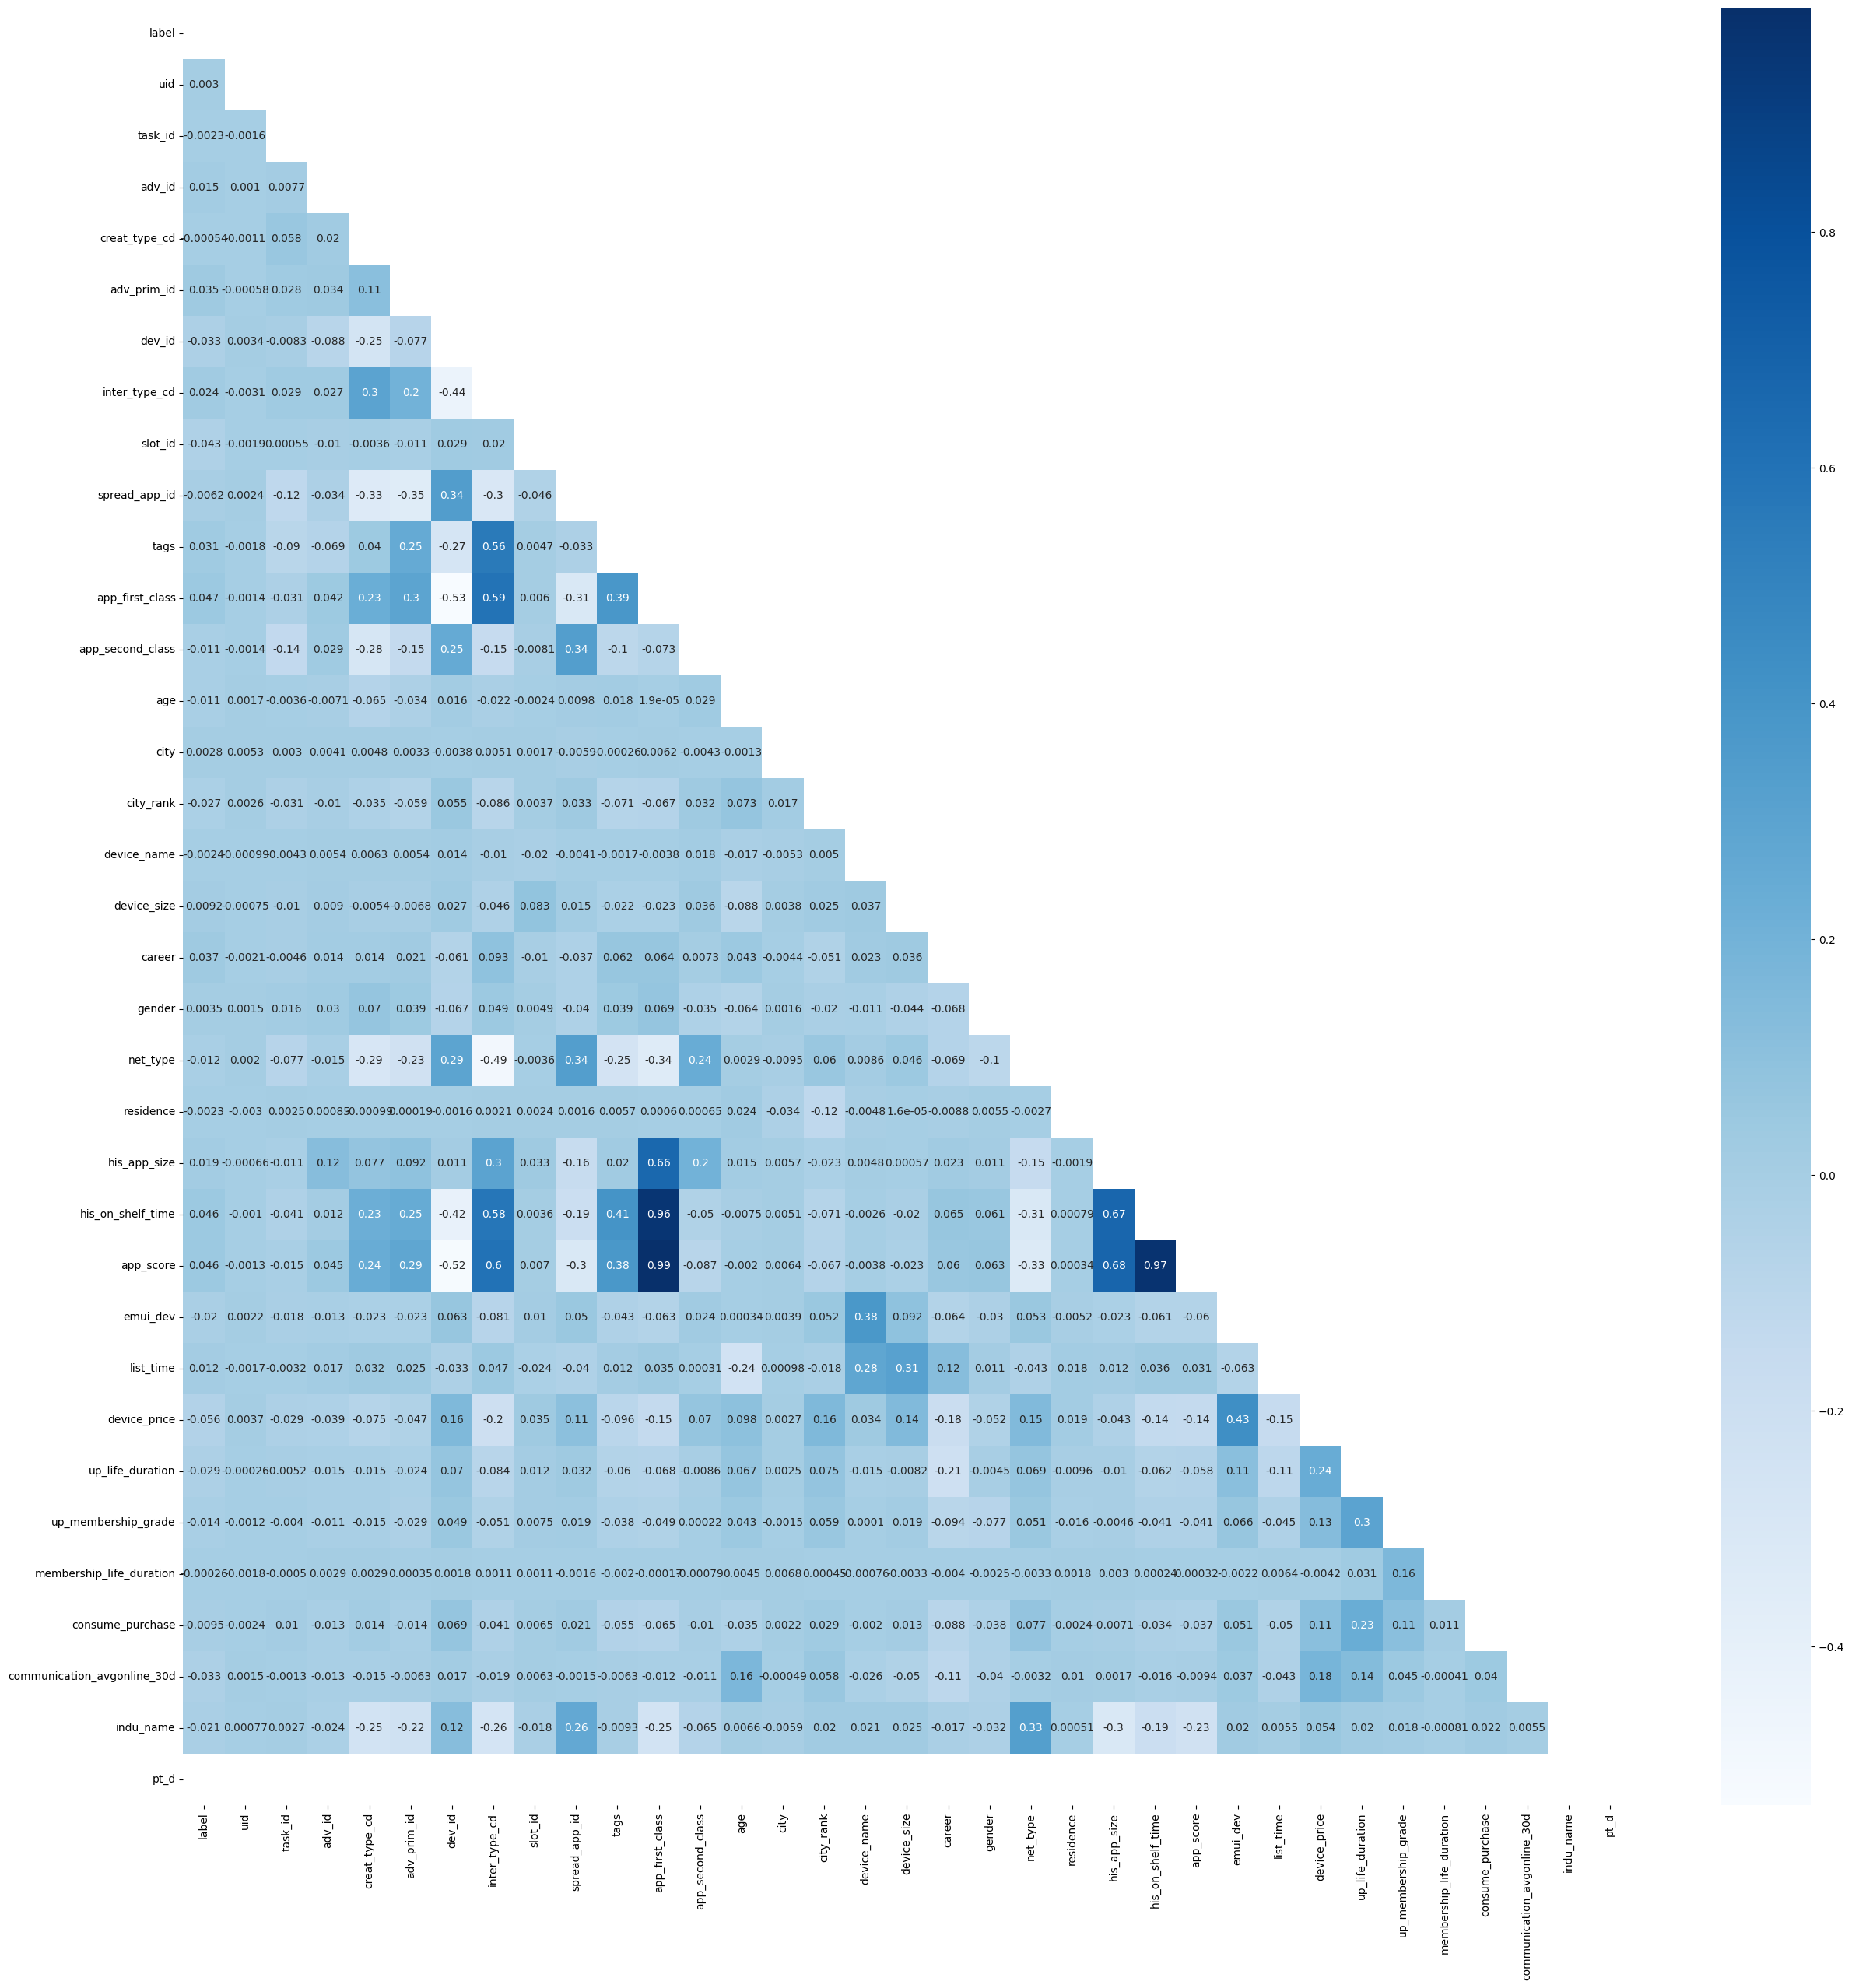

In [8]:
plt.figure(figsize=(30, 30))
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
corr_heatmap=sns.heatmap(edited_file.corr(), cmap="Blues", annot=True, mask=mask)

#### 히트맵 덕분에 변수 간의 주요 관계를 유추할 수 있으며, 이러한 관계는 이해관계자들에게 가치가 있을 수 있습니다.
#### 광고 업무의 앱 태그(tags)는 앱 평점 점수(app_score)와 강한 양의 관계를 가지며, 이는 인기 앱에서 어떤 광고 태스크를 사용하는지를 알게 하거나, 해당 광고 태스크가 지금까지 앱의 인기를 높이는 데 사용되었음을 시사할 수 있습니다.
#### 앱 평점 점수(app_score)는 광고의 노출 형태(inter_typ_cd)와 더 강한 양의 관계를 가지고 있어, 어떤 광고 형태가 다른 광고 형태보다 앱의 인기도를 높이는 데 더 효과적이라는 것을 암시할 수 있습니다.
#### 데이터 설명에 따르면 대부분의 값이 최대값인 2이기 때문에 앱 평점 점수에 대한 보다 정확한 인사이트를 유추하기 어렵고, 따라서 데이터가 크게 편향되어 있습니다. 박스 플롯은 이를 시각화합니다:

<Axes: >

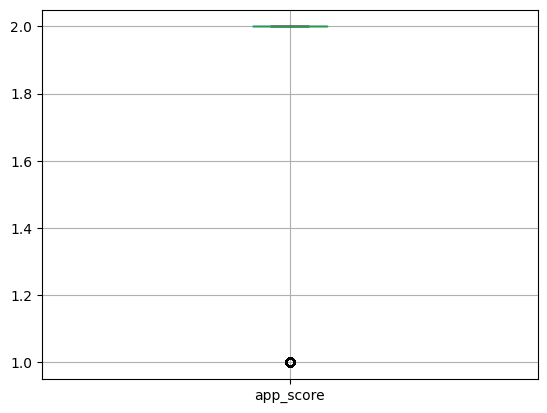

In [9]:
edited_file.boxplot(column='app_score')

#### app_score 값은 대부분 '2'이며, 드물게 '1'인 경우도 있는데, 이러한 값들은 이상값으로 간주됩니다.
#### 데이터 설명에 따르면 더 잘 분포되어 있는 것으로 보이는 또 다른 변수인 his_app_size를 살펴보겠습니다.

<Axes: >

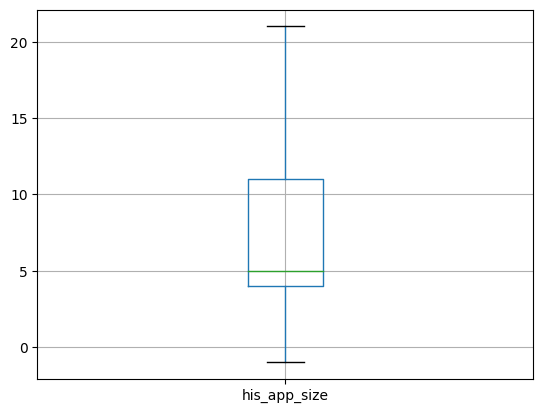

In [10]:
edited_file.boxplot(column='his_app_size')

#### 앱 스토리지 용량(his_app_size)는 앱 점수, 앱 출시 시간 및 광고의 앱 레벨 1 카테고리(app_first_class)와 매우 강한 양의 관계를 보입니다.
#### 예를 들어 최근에 출시된 앱의 저장 용량이 더 크다는 것 등 여러 가지 의미가 있을 수 있습니다.
#### 데이터가 원래 암호화되어 있기 때문에 관계 이상의 많은 것을 추론하기는 어렵습니다.
#### 히스토그램은 다양한 변수와 변수가 얼마나 왜곡되어 있는지에 대한 이해를 높여줍니다.

array([[<Axes: title={'center': 'label'}>,
        <Axes: title={'center': 'uid'}>,
        <Axes: title={'center': 'task_id'}>,
        <Axes: title={'center': 'adv_id'}>,
        <Axes: title={'center': 'creat_type_cd'}>,
        <Axes: title={'center': 'adv_prim_id'}>],
       [<Axes: title={'center': 'dev_id'}>,
        <Axes: title={'center': 'inter_type_cd'}>,
        <Axes: title={'center': 'slot_id'}>,
        <Axes: title={'center': 'spread_app_id'}>,
        <Axes: title={'center': 'tags'}>,
        <Axes: title={'center': 'app_first_class'}>],
       [<Axes: title={'center': 'app_second_class'}>,
        <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'city'}>,
        <Axes: title={'center': 'city_rank'}>,
        <Axes: title={'center': 'device_name'}>,
        <Axes: title={'center': 'device_size'}>],
       [<Axes: title={'center': 'career'}>,
        <Axes: title={'center': 'gender'}>,
        <Axes: title={'center': 'net_type'}>,
        <Axes: title={

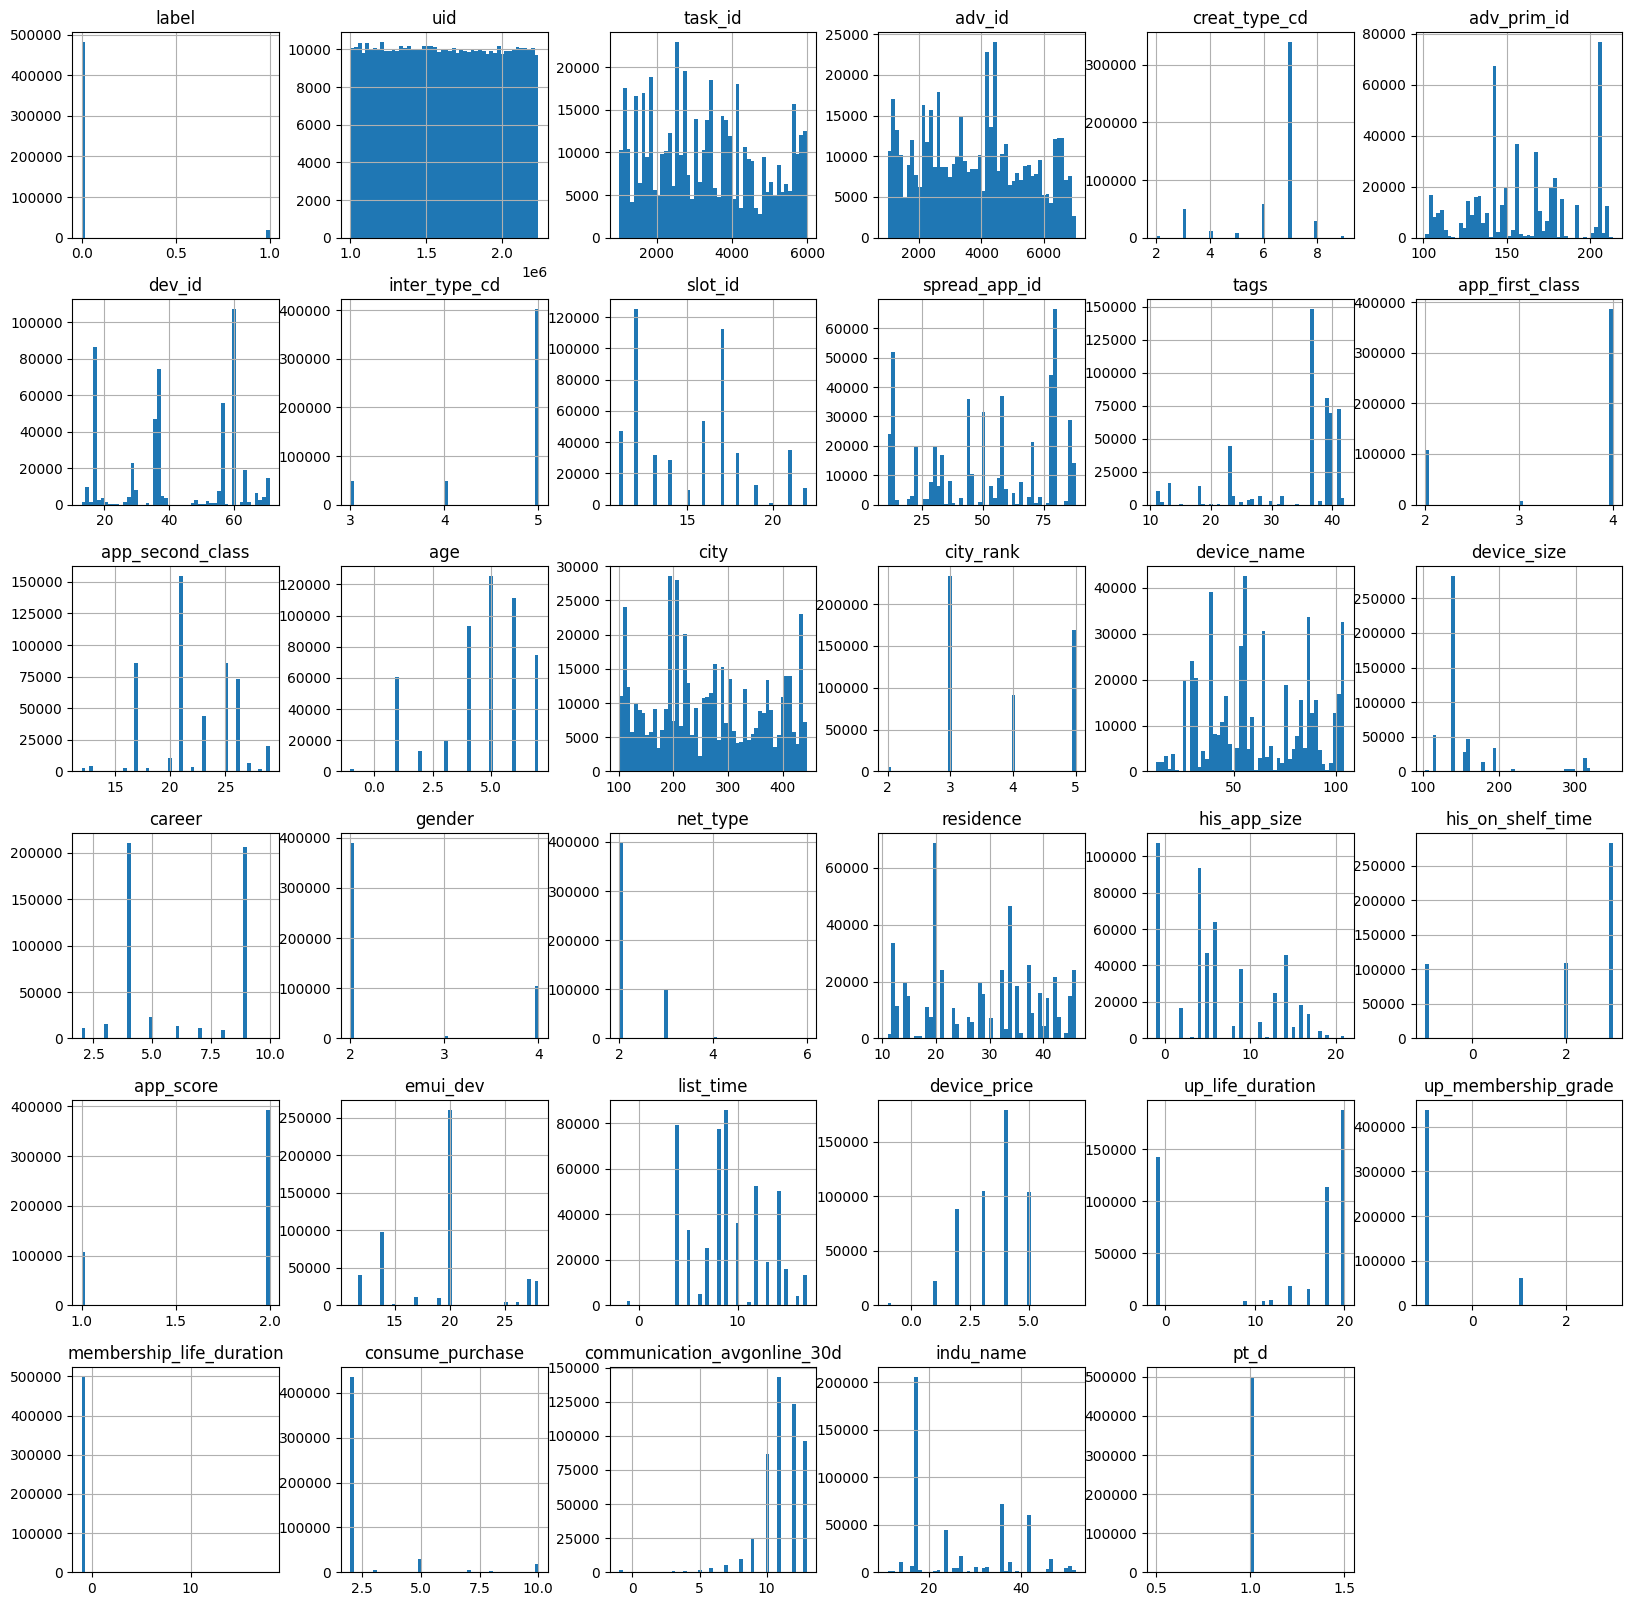

In [11]:
edited_file.hist(figsize=(20,20), bins=50)

#### 예측하려고 하는 변수인 'label'=1은 드물게 발생하며 히트맵에 따르면 다른 변수는 이 변수와 강한 관계가 없습니다. 따라서 어떤 예측 모델도 잠재력이 매우 제한적입니다.

In [12]:
edited_file['label'].value_counts()[1] / 500000

0.036942

## Data Cleaning
#### 데이터를 확인하고 null값을 검색하겠습니다.

In [13]:
edited_file.isnull().sum()

label                          0
uid                            0
task_id                        0
adv_id                         0
creat_type_cd                  0
adv_prim_id                    0
dev_id                         0
inter_type_cd                  0
slot_id                        0
spread_app_id                  0
tags                           0
app_first_class                0
app_second_class               0
age                            0
city                           0
city_rank                      0
device_name                    0
device_size                    0
career                         0
gender                         0
net_type                       0
residence                      0
his_app_size                   0
his_on_shelf_time              0
app_score                      0
emui_dev                       0
list_time                      0
device_price                   0
up_life_duration               0
up_membership_grade            0
membership

#### 다행히 결측치가 없습니다. 만약 결측치가 존재할 경우 null값을 포함하는 변수를 다른 값으로 대치하거나 이를 포함하는 행을 삭제해야 합니다.

## Feature Engineering
#### 이제 'communication_onlinerate' 변수를 처리하고 다른 변수를 축소한 다음 데이터를 훈련 세트와 테스트 세트로 분할할 차례입니다.
#### 훈련 세트 변수가 테스트 세트에 최대한 가깝게 분포되도록 데이터 세트 분할이 이루어지도록 하기 위해 'StratifiedShuffleSplit'을 사용합니다.
#### 세트 분할은 'adv_prim_id' 변수를 초점으로 이루어질 것입니다. 'adv_prim_id' 변수와 비슷한 수준으로 'label'과의 관계를 가지는 다른 변수들에 비해서 상대적으로 잘 분포되어 있기 때문입니다.

In [14]:
communication_onlinerate=edited_file['communication_onlinerate'].value_counts()[edited_file['communication_onlinerate'].value_counts()>50]
communication_onlinerate=pd.DataFrame(communication_onlinerate.index)

In [15]:
cat_encoder=OneHotEncoder(sparse=False, handle_unknown='ignore')
cat_encoder.fit(communication_onlinerate.values.reshape(-1,1))
communication_onlinerate_encoded=pd.DataFrame(cat_encoder.transform(edited_file['communication_onlinerate'].values.reshape(-1,1)))
features=list(edited_file.columns)
features=features+cat_encoder.categories_[0].tolist()
features.remove('communication_onlinerate')
engineered_data=edited_file.join(communication_onlinerate_encoded)
engineered_data=engineered_data.drop(columns=['communication_onlinerate'])
engineered_data.columns = engineered_data.columns.astype(str)


split=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in split.split(engineered_data, engineered_data['adv_prim_id']):
    strat_train_set=engineered_data.loc[train_index]
    strat_test_set=engineered_data.loc[test_index]

train_labels=strat_train_set['label']
test_labels=strat_test_set['label']
strat_train_set=strat_train_set.drop(columns=['label'])
strat_test_set=strat_test_set.drop(columns=['label'])

scaler=StandardScaler()
strat_train_set=pd.DataFrame(scaler.fit_transform(strat_train_set))
strat_test_set=pd.DataFrame(scaler.fit_transform(strat_test_set))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [16]:
del cat_encoder
del communication_onlinerate_encoded
del scaler

## Algorithm Selection
#### 모델 평가에 사용되는 metric: AUC
##### AUC가 1이면 분리 능력이 우수하다는 의미이고, AUC가 0.5이면 모델에 클래스 분리 능력이 없다는 의미입니다.

### Decision Trees


In [17]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(strat_train_set, train_labels)
roc_auc_score(test_labels, dtc.predict_proba(strat_test_set)[:, 1])

0.5282614986806445

In [18]:
dtc = DecisionTreeClassifier(random_state=0)
scores=cross_val_score(dtc,strat_train_set ,train_labels , cv=10, scoring='roc_auc')
scores

array([0.5312623 , 0.53027841, 0.53325533, 0.52826946, 0.53888935,
       0.52200526, 0.52949263, 0.53497275, 0.52891095, 0.53110849])

In [19]:
forest=RandomForestClassifier(n_estimators=30, random_state=0)
forest.fit(strat_train_set, train_labels)
roc_auc_score(test_labels, forest.predict_proba(strat_test_set)[:, 1])

0.6346441602153678

#### 랜덤 포레스트 분류기가 의사 결정 트리 분류기보다 낫다는 사실은 그다지 놀랍지 않습니다. 하지만 최상의 매개 변수를 사용한 게 맞을까요? 알고리즘이 더 나은 성능을 낼 수 있을지도 모릅니다.

### Hyperparameter tuning

In [34]:
params= {'n_estimators':randint(low=1, high=200), 'max_features':randint(low=1, high=10)}
forest=RandomForestClassifier(random_state=0)
rnd_search=RandomizedSearchCV(forest, param_distributions=params, n_iter=10, cv=5, scoring='roc_auc', random_state=0)
rnd_search.fit(strat_train_set, train_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fc75b75faf0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fc75b858550>},
                   random_state=0, scoring='roc_auc')

In [35]:
cvres=rnd_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

0.6766580638921493 {'max_features': 6, 'n_estimators': 193}
0.67410006406204 {'max_features': 4, 'n_estimators': 196}
0.594030077464517 {'max_features': 8, 'n_estimators': 10}
0.6173701617628498 {'max_features': 4, 'n_estimators': 22}
0.6353124569209324 {'max_features': 3, 'n_estimators': 37}
0.6600381646271519 {'max_features': 8, 'n_estimators': 71}
0.6622133661444328 {'max_features': 9, 'n_estimators': 89}
0.6348006806256523 {'max_features': 2, 'n_estimators': 40}
0.6736819488131577 {'max_features': 8, 'n_estimators': 175}
0.6605417705010319 {'max_features': 9, 'n_estimators': 82}


#### 위의 값들은 RandomForestClassifier 모델에 사용하기에 가장 적합한 파라미터입니다. 이는 다른 무작위로 지정된 파라미터들을 포함한 RandomForestClassifier 모델들 중에서 가장 높은 AUC를 가진 모델을 제공할 것입니다.

In [36]:
y_predict1 = pd.DataFrame(rnd_search.best_estimator_.predict(strat_test_set))
y_predict1.value_counts()[1] / 500000

0.00045

## XGboost

In [23]:
scale_pos_weight = edited_file['label'].value_counts()[0] / edited_file['label'].value_counts()[1]
xg_class= xgb.XGBClassifier(random_state=0, use_label_encoder=False)
params=  {'n_estimators': randint(50, 400),
              'learning_rate': uniform(0.01, 0.59),
              'subsample': uniform(0.3, 0.6),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': uniform(0.4, 0.5),
              'min_child_weight': [1, 2, 3, 4],
              'scale_pos_weight': [scale_pos_weight] }
rnd_search=RandomizedSearchCV(xg_class, param_distributions = params, cv = 5,n_iter = 10, scoring = 'roc_auc', error_score = 0, verbose = 3, n_jobs = -1)
rnd_search.fit(strat_train_set, train_labels, eval_metric='mlogloss')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


RandomizedSearchCV(cv=5, error_score=0,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fc75b2cbdc0>,
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fc75b48f1f0>,
                                        'scale_pos_weight': [26.069460234962914],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fc75b2cb2b0>},
                   scoring='roc_auc', verbose=3)

In [24]:
cvres=rnd_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print (mean_score, params)

0.6969816301949076 {'colsample_bytree': 0.6462242471088844, 'learning_rate': 0.5687172162601759, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 119, 'scale_pos_weight': 26.069460234962914, 'subsample': 0.5572966627781002}
0.6306460823366653 {'colsample_bytree': 0.5609850071871637, 'learning_rate': 0.5583891199372272, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 166, 'scale_pos_weight': 26.069460234962914, 'subsample': 0.7073247083077352}
0.6940843762188006 {'colsample_bytree': 0.8594889177068519, 'learning_rate': 0.0870746378479047, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 191, 'scale_pos_weight': 26.069460234962914, 'subsample': 0.31108765658186494}
0.7071673215062935 {'colsample_bytree': 0.6215494546009976, 'learning_rate': 0.41751861057287626, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 89, 'scale_pos_weight': 26.069460234962914, 'subsample': 0.757049620625623}
0.6755465624600091 {'colsample_bytree': 0.7755640734630442, 'learning_rate': 0.3

#### 위의 값들은 XGBClassifier 모델에 사용하기에 가장 적합한 파라미터입니다. 이는 다른 무작위로 지정된 파라미터들을 포함한 XGBClassifier 모델들 중에서 가장 높은 AUC를 가진 모델을 제공할 것입니다.

#### 하이퍼파라미터가 잘 조정된 경우 XGBClassifier가 RandomForestClassifier보다 선호되는 모델입니다.


In [33]:
y_predict2 = pd.DataFrame(rnd_search.best_estimator_.predict(strat_test_set))
y_predict2.value_counts()[1] / 500000

0.051338